# Setup of Colab Environment
---

Every Colab runs it's own instance on cloud. We need setup workshop enviroment in those steps:  
* Setup GPU instance: Runtime ->  Change runtime type 
* Install workshop package with all requiremetns from git
* Import all packages
* Mount GDrive  

In [ ]:
!pip install git+https://github.com/adamoz/colab_image_processing_workshop_torch.git

In [ ]:
# Basic tools
from image_processing_workshop.utils import get_image_from_url
from image_processing_workshop.utils import get_imagenet_category_names
from image_processing_workshop.utils import get_patch, apply_patch
from collections import deque
from google.colab import drive
from google.colab import files
from shutil import rmtree
import tqdm
import pandas as pd
import numpy as np
import torch
import os

# Datasets
from image_processing_workshop.utils import scrape_urls
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor
from torchvision.datasets import FashionMNIST
from torchvision import models
from torchvision import utils

# Architecture of NN
from torch import nn
import torch.nn.functional as F
from torch.nn import Module, Sequential
from torch.nn import ReLU, Tanh, Dropout, Softmax, Linear, BatchNorm1d, Conv2d, MaxPool2d, BatchNorm2d
from torch.nn.init import xavier_uniform_, normal_

# Training
from torch.nn import MSELoss, CrossEntropyLoss, NLLLoss
from torch.optim import Adam, SGD

# Metrics
from image_processing_workshop.eval import get_results_df
from image_processing_workshop.eval import get_precision
from image_processing_workshop.eval import get_recall
from image_processing_workshop.eval import get_rec_prec
from image_processing_workshop.eval import get_accuracy
from image_processing_workshop.eval import get_false_positives

# Visualization
import matplotlib.pyplot as plt
from image_processing_workshop.visual import plot_classify, plot_image
from image_processing_workshop.visual import plot_df_examples
from image_processing_workshop.visual import plot_coocurance_matrix

In [ ]:
drive.mount('./drive', force_remount=True)

In [ ]:
os.listdir('./drive/My Drive/ml_college_data')

# Introduction to Resnet18
---

## Architecture

PyTorch tooling related to image processing can be found in `torchvision` module. Information about accessible pretrained models for PyTorch can be found at ***https://pytorch.org/docs/stable/torchvision/models.html***.

In [ ]:
resnet18 = models.resnet18()
resnet18

In [ ]:
conv1 = resnet18.layer4[0].conv1
conv1

## Prediction with pretrained model

In [ ]:
# Default path where to save pretrained models.
if not os.path.isdir('./drive/My Drive/ml_college_data/models'):
  os.makedirs('./drive/My Drive/ml_college_data/models')
os.environ["TORCH_HOME"] = "./drive/My Drive/ml_college_data/models"

In [ ]:
models.resnet.model_urls

In [ ]:
resnet18 = models.resnet18(pretrained=True)
info = resnet18.eval()

In [ ]:
url = 'https://media.wired.com/photos/5b86fce8900cb57bbfd1e7ee/master/pass/Jaguar_I-PACE_S_Indus-Silver_065.jpg'
img = get_image_from_url(url)
plot_image(img)

In [ ]:
# Transformation for resnet, normalization is important!!
transformation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
transformed_img = transformation(img)

In [ ]:
img.shape, transformed_img.shape

In [ ]:
batch = transformed_img.unsqueeze(0)
resnet18(batch)[0][:10]

In [ ]:
# Let's adjust last layer and add softmax, softmax doesn't need training, it's just normalization.
resnet18.fc = torch.nn.Sequential(
    resnet18.fc, 
    torch.nn.Softmax(dim=1))

In [ ]:
resnet18(batch)[0][:10]

In [ ]:
get_imagenet_category_names(use_cache=True)[:10]

In [ ]:
plot_classify(transformed_img, resnet18, topn=5, category_names=get_imagenet_category_names(), figsize=(15,15))

In [ ]:
url = 'https://s.w-x.co/util/image/w/411spacex.jpg?v=at&w=815&h=458'
img = get_image_from_url(url)
transformed_img = transformation(img)
plot_classify(transformed_img, resnet18, topn=5, category_names=get_imagenet_category_names())

# Security of models
---

Can we fool the models? 


## Prepare models

In [ ]:
info = resnet18.eval()

In [ ]:
squeezenet = models.squeezenet1_1(pretrained=True)
squeezenet.classifier = torch.nn.Sequential(
    squeezenet.classifier, 
    torch.nn.Softmax(dim=1))

info = squeezenet.eval()

## Classify image to ImageNet categories

In [ ]:
url1 = 'http://british-samoyed-club.co.uk/bsc/wp-content/uploads/scooter.jpg'

In [ ]:
img = get_image_from_url(url1, resize=[600])
plot_image(img)

In [ ]:
transformed_img = transformation(img)
plot_classify(transformed_img, resnet18, topn=5, category_names=get_imagenet_category_names(), figsize=(10,10))

## Patch the images

In [ ]:
patches = get_patch()
plot_image(patches)

In [ ]:
# Select your model and image
url = url1
model = resnet18

In [ ]:
img = get_image_from_url(url, resize=[600])
plot_image(img)

In [ ]:
patch = get_patch(2, resize=[200])
plot_image(patch)

In [ ]:
img_patched = apply_patch(img, patch, pos_w=200, pos_h=0)
plot_image(img_patched)

In [ ]:
transformed_img = transformation(img_patched)
plot_classify(transformed_img, model, topn=5, category_names=get_imagenet_category_names(), figsize=(10,10))

# Transfer learning
---


In this final part, we will
 - create our custom dataset
 - finetune resnet 18
 - evaluate final results (and optionally iterate on dataset to improve it)

## Building of our dataset

### Scrape image url
 - go to Google images https://www.google.com/imghp?hl=EN
 - search image category and scroll a bit through it
 - run console `Ctrl-Shift-J`
 - paste javascript snippet to console  

```javascript
javascript:document.body.innerHTML = `<a href="data:text/csv;charset=utf-8,${escape(Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou).join('\n'))}" download="urls.txt">download urls</a>`;
```

 - rename `urls.txt` in `download="urls.txt"` according to category you scrape e.g. `cats.txt`
 - download image urls
 - copy `cats.txt` to docker shared folder with this ipython notebook

### Download images to proper folder hierarchy
 - run `scrape_urls` with url file and appropriate category name
 - each run of `scrape_urls` will create following folder hierarchy
 
`root_folder/train/class_name/*.jpg`   
`root_folder/valid/class_name/*.jpg`

In [ ]:
root_folder = './drive/My Drive/ml_college_data/dataset_ceos'

In [47]:
scrape_urls(root_folder + '/satya_nadella.txt', category_name='Satya Nadella', root_folder=root_folder)

  3%|▎         | 8/300 [00:01<01:06,  4.39it/s]

HTTP Error 403: Forbidden


  3%|▎         | 9/300 [00:01<01:03,  4.58it/s]

HTTP Error 403: Forbidden


  7%|▋         | 21/300 [00:06<02:38,  1.76it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/satya-bio.jpg


  8%|▊         | 24/300 [00:07<01:31,  3.01it/s]

HTTP Error 403: Forbidden


 10%|▉         | 29/300 [00:09<01:39,  2.73it/s]

HTTP Error 403: Forbidden


 11%|█         | 33/300 [00:09<01:00,  4.43it/s]

HTTP Error 403: Forbidden


 12%|█▏        | 36/300 [00:24<14:29,  3.29s/it]

<urlopen error timed out>
HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 13%|█▎        | 39/300 [00:25<05:23,  1.24s/it]

HTTP Error 403: Forbidden


 14%|█▎        | 41/300 [00:25<03:50,  1.12it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/The_whining_is_over_How-2d79e103934b87afeaa28782dbbb3967.jpg


 16%|█▌        | 48/300 [00:29<02:01,  2.07it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/Satya-Nadella-500x250.jpg


 19%|█▊        | 56/300 [00:33<01:47,  2.28it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/181311-004-46EFA8B7.jpg


 19%|█▉        | 58/300 [00:33<01:12,  3.36it/s]

HTTP Error 403: Forbidden


 20%|██        | 61/300 [00:35<01:36,  2.48it/s]

HTTP Error 403: Forbidden


 22%|██▏       | 65/300 [00:37<02:27,  1.60it/s]

HTTP Error 403: Forbidden


 26%|██▌       | 77/300 [00:48<05:29,  1.48s/it]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/59dff8770fb426ec40abf65e4ddda027.jpg


 27%|██▋       | 82/300 [00:49<02:04,  1.76it/s]

HTTP Error 403: Forbidden


 31%|███▏      | 94/300 [00:57<01:43,  2.00it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/Satya-Nadella-2.jpg


 36%|███▋      | 109/300 [01:05<01:12,  2.63it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 40%|████      | 120/300 [01:10<00:53,  3.36it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 41%|████      | 122/300 [01:10<00:44,  4.00it/s]

HTTP Error 403: Forbidden


 42%|████▏     | 126/300 [01:11<00:54,  3.20it/s]

hostname 'chicagobooth.eu' doesn't match either of 'chicagobooth.edu', '*.chicagobooth.edu', '*.test.chicagobooth.edu'


 44%|████▎     | 131/300 [01:14<00:58,  2.88it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/59dff8770fb426ec40abf65e4ddda027.jpg


 44%|████▍     | 132/300 [01:14<01:05,  2.58it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/BigSpeak-Motivational-Speakers-Bureau-Satya-Nadella.jpg


 45%|████▌     | 136/300 [01:17<01:05,  2.52it/s]

HTTP Error 403: Forbidden


 46%|████▋     | 139/300 [01:19<01:41,  1.58it/s]

HTTP Error 403: Forbidden


 49%|████▊     | 146/300 [01:21<00:51,  3.02it/s]

HTTP Error 403: Forbidden


 51%|█████     | 152/300 [01:24<01:27,  1.69it/s]

HTTP Error 403: Forbidden


 52%|█████▏    | 156/300 [01:26<01:09,  2.07it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/?url=http%3A%2F%2Fs3-origin-images.jpg


 54%|█████▍    | 163/300 [01:34<01:32,  1.49it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 56%|█████▌    | 167/300 [01:35<01:23,  1.59it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/satya-nadella-4.jpg


 56%|█████▋    | 169/300 [01:36<00:58,  2.24it/s]

<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)>


 58%|█████▊    | 174/300 [01:39<01:13,  1.71it/s]

HTTP Error 403: Forbidden


 59%|█████▊    | 176/300 [01:42<01:49,  1.13it/s]

HTTP Error 404: Not Found


 60%|██████    | 181/300 [01:45<01:13,  1.62it/s]

HTTP Error 403: Forbidden


 62%|██████▏   | 185/300 [01:46<00:49,  2.32it/s]

HTTP Error 500: Internal Server Error


 62%|██████▏   | 186/300 [01:46<00:42,  2.71it/s]

HTTP Error 404: Not Found


 62%|██████▏   | 187/300 [01:48<01:07,  1.67it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/76558_20150714nadella_08.jpg


 63%|██████▎   | 188/300 [01:49<01:23,  1.34it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/201703ehm07.jpg


 63%|██████▎   | 190/300 [01:50<01:29,  1.23it/s]

HTTP Error 403: Forbidden


 66%|██████▌   | 198/300 [01:57<01:02,  1.63it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/TCP151-1024x576.jpg


 67%|██████▋   | 201/300 [01:59<01:10,  1.40it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/Satya%20Nadella%20at%20Microsoft%20Build%202018.jpg


 68%|██████▊   | 204/300 [02:00<00:39,  2.42it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/Nadella.jpg


 70%|██████▉   | 209/300 [02:04<00:58,  1.55it/s]

HTTP Error 403: Forbidden


 70%|███████   | 210/300 [02:04<00:46,  1.93it/s]

HTTP Error 403: Forbidden


 71%|███████   | 212/300 [02:05<00:42,  2.05it/s]

<urlopen error [Errno -2] Name or service not known>


 71%|███████▏  | 214/300 [02:05<00:33,  2.54it/s]

HTTP Error 403: Forbidden


 72%|███████▏  | 217/300 [02:06<00:21,  3.87it/s]

HTTP Error 403: Forbidden


 73%|███████▎  | 219/300 [02:09<01:09,  1.17it/s]

HTTP Error 403: Forbidden


 74%|███████▍  | 223/300 [02:10<00:36,  2.08it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/hit-refresh-satya-nadella-microsoft.jpg


 76%|███████▌  | 228/300 [02:14<00:35,  2.02it/s]

HTTP Error 404: Not Found


 77%|███████▋  | 230/300 [02:14<00:23,  2.93it/s]

HTTP Error 403: Forbidden


 78%|███████▊  | 233/300 [02:15<00:21,  3.16it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/Heidi-Moore,-L.jpg


 79%|███████▉  | 237/300 [02:17<00:26,  2.35it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/Satya-Nadella-6.jpg


 80%|████████  | 240/300 [02:20<00:42,  1.41it/s]

HTTP Error 403: Forbidden


 80%|████████  | 241/300 [02:20<00:37,  1.56it/s]

HTTP Error 403: Forbidden


 81%|████████  | 243/300 [02:20<00:28,  2.00it/s]

<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)>


 81%|████████▏ | 244/300 [02:21<00:31,  1.79it/s]

HTTP Error 404: Not Found
HTTP Error 403: Forbidden


 83%|████████▎ | 250/300 [02:22<00:14,  3.43it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 84%|████████▍ | 253/300 [02:23<00:11,  4.21it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/Satya_Nadella_Octocat-779x367.jpg
HTTP Error 403: Forbidden
Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/Satya-Narayana-Nadella-HD-Wallpaper-e1522752514548.jpg


 86%|████████▌ | 257/300 [02:24<00:12,  3.51it/s]

HTTP Error 403: Forbidden


 87%|████████▋ | 261/300 [02:26<00:13,  2.97it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/Satya-Nadella-3.jpg


 88%|████████▊ | 265/300 [02:29<00:20,  1.68it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/pQFaTHbboFyhmqCmzLtxS8-320-80.jpg
HTTP Error 403: Forbidden


 90%|█████████ | 270/300 [02:31<00:17,  1.76it/s]

HTTP Error 403: Forbidden
<urlopen error [Errno -2] Name or service not known>


 91%|█████████▏| 274/300 [02:33<00:09,  2.62it/s]

HTTP Error 403: Forbidden


 92%|█████████▏| 277/300 [02:35<00:15,  1.53it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella/satya_vivatech-20180524030259152.jpg


 93%|█████████▎| 279/300 [02:36<00:12,  1.64it/s]

HTTP Error 403: Forbidden


 95%|█████████▌| 286/300 [02:40<00:08,  1.73it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/?url=https%3A%2F%2Fstatic.jpg
HTTP Error 403: Forbidden


 96%|█████████▋| 289/300 [02:41<00:05,  1.87it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/1391523514-9894.jpg


 97%|█████████▋| 292/300 [02:43<00:04,  1.76it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella/blog_satya.jpg


 99%|█████████▊| 296/300 [02:45<00:02,  1.74it/s]

HTTP Error 404: Not Found
HTTP Error 403: Forbidden
<urlopen error [Errno -2] Name or service not known>


100%|██████████| 300/300 [02:45<00:00,  3.00it/s]

hostname 'chicagobooth.eu' doesn't match either of 'chicagobooth.edu', '*.chicagobooth.edu', '*.test.chicagobooth.edu'
Failed 85
Succ 215


('./drive/My Drive/ml_college_data/dataset_ceos/train/Satya Nadella',
 './drive/My Drive/ml_college_data/dataset_ceos/valid/Satya Nadella')

In [48]:
scrape_urls(root_folder + '/sundar_pichai.txt', category_name='Sundar Pichai', root_folder=root_folder)

  5%|▌         | 16/300 [00:05<01:22,  3.45it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/220px-Sundar_Pichai_%28cropped%29.jpg


  7%|▋         | 20/300 [00:08<02:15,  2.07it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Sundar Pichai/0cfd75a669357fd426fc2606d2bb9e34.jpg


  8%|▊         | 24/300 [00:09<01:34,  2.91it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Sundar Pichai/193142-004-55BEAB55.jpg


 12%|█▏        | 35/300 [00:13<01:28,  3.01it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/?w=620&h=413&crop=1&hash=21508F013A17AE24F34737BBF73B3B6401042E50.jpg
HTTP Error 403: Forbidden


 14%|█▍        | 43/300 [00:16<02:33,  1.68it/s]

HTTP Error 403: Forbidden


 15%|█▌        | 46/300 [00:17<01:36,  2.62it/s]

HTTP Error 404: Not Found


 16%|█▋        | 49/300 [00:18<01:25,  2.94it/s]

HTTP Error 403: Forbidden


 18%|█▊        | 53/300 [00:19<01:27,  2.81it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 18%|█▊        | 54/300 [00:20<01:36,  2.54it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/AVKqN4W33_nRjf708THj353Pp2I52EMAbrDO8X7n5OI.jpg


 21%|██        | 62/300 [00:22<01:02,  3.81it/s]

HTTP Error 403: Forbidden


 22%|██▏       | 65/300 [00:23<01:32,  2.53it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/sundar-pichai.jpg


 26%|██▌       | 78/300 [00:29<01:27,  2.54it/s]

HTTP Error 403: Forbidden


 27%|██▋       | 81/300 [00:33<02:46,  1.31it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 28%|██▊       | 85/300 [00:35<02:31,  1.42it/s]

HTTP Error 403: Forbidden


 31%|███       | 92/300 [00:38<01:16,  2.73it/s]

HTTP Error 403: Forbidden
Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/5191.jpg


 32%|███▏      | 96/300 [00:38<00:46,  4.36it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 33%|███▎      | 100/300 [00:40<01:04,  3.08it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 34%|███▍      | 103/300 [00:41<01:26,  2.28it/s]

HTTP Error 403: Forbidden


 42%|████▏     | 125/300 [00:51<01:12,  2.40it/s]

HTTP Error 403: Forbidden


 42%|████▏     | 127/300 [00:52<01:05,  2.66it/s]

HTTP Error 403: Forbidden


 43%|████▎     | 130/300 [01:02<04:47,  1.69s/it]

HTTP Error 403: Forbidden


 46%|████▌     | 137/300 [01:04<01:16,  2.14it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/7_sundar_pichai.jpg


 46%|████▋     | 139/300 [01:05<00:50,  3.17it/s]

HTTP Error 403: Forbidden


 47%|████▋     | 141/300 [01:05<00:49,  3.20it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/Screen-Shot-2018-12-11-at-10.jpg


 50%|█████     | 150/300 [01:12<01:43,  1.45it/s]

HTTP Error 403: Forbidden


 52%|█████▏    | 155/300 [01:13<00:45,  3.20it/s]

HTTP Error 404: Not Found


 52%|█████▏    | 157/300 [01:14<00:52,  2.73it/s]

HTTP Error 403: Forbidden


 55%|█████▌    | 166/300 [01:19<00:46,  2.90it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/200px-Sundar_Pichai_September_2015.jpg


 56%|█████▋    | 169/300 [01:19<00:35,  3.69it/s]

HTTP Error 403: Forbidden


 57%|█████▋    | 172/300 [01:21<00:55,  2.31it/s]

HTTP Error 403: Forbidden


 59%|█████▊    | 176/300 [01:22<00:48,  2.54it/s]

HTTP Error 403: Forbidden


 61%|██████    | 183/300 [01:28<01:35,  1.22it/s]

HTTP Error 500: Internal Server Error
HTTP Error 403: Forbidden


 63%|██████▎   | 190/300 [01:33<01:28,  1.24it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/Sundar%20Pichai.jpg


 64%|██████▎   | 191/300 [01:33<01:21,  1.33it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/SundarPichai.jpg


 65%|██████▌   | 196/300 [01:35<00:40,  2.55it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/main-qimg-e7c93566dc9bd6a30a3ca227f4d02153.jpg


 68%|██████▊   | 205/300 [01:39<00:44,  2.14it/s]

HTTP Error 403: Forbidden


 71%|███████▏  | 214/300 [01:44<00:55,  1.56it/s]

HTTP Error 403: Forbidden


 72%|███████▏  | 216/300 [01:45<00:39,  2.10it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/Google-Sundar-Pichai-google-IO-2018.jpg


 74%|███████▍  | 222/300 [01:47<00:29,  2.67it/s]

[Errno 22] Invalid argument: './drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/washington-united-states-of-america-11th-dec-2018-sundar-pichai-chief-executive-officer-of-google-testifies-before-the-united-states-house-committee-on-the-judiciary-on-transparency-accountability-examining-google-and-its-data-collection-use-and-filtering-practices-on-capitol-hill-in-washington-dc-on-tuesday-december-11-2018-credit-ron-sachscnp-restriction-no-new-york-or-new-jersey-newspapers-or-newspapers-within-a-75-mile-radius-of-new-york-city-usage-worldwide-credit-dpaalamy-live-news-R836EJ.jpg'


 74%|███████▍  | 223/300 [01:47<00:27,  2.82it/s]

HTTP Error 403: Forbidden


 77%|███████▋  | 232/300 [01:52<00:24,  2.72it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Sundar Pichai/6132.jpg


 80%|███████▉  | 239/300 [01:55<00:21,  2.85it/s]

HTTP Error 403: Forbidden


 81%|████████▏ | 244/300 [02:01<00:49,  1.14it/s]

HTTP Error 404: Not Found


 86%|████████▋ | 259/300 [02:08<00:22,  1.79it/s]

HTTP Error 404: File Not Found


 89%|████████▉ | 267/300 [02:13<00:13,  2.39it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai/3065420-inline-i-10-secrets-of-the-most-productive-people-sundar-pichai.jpg


 91%|█████████ | 272/300 [02:15<00:10,  2.61it/s]

HTTP Error 403: Forbidden


 91%|█████████▏| 274/300 [02:16<00:11,  2.23it/s]

HTTP Error 403: Forbidden


 96%|█████████▌| 288/300 [02:21<00:02,  4.23it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Sundar Pichai/250px-Sundar_Pichai_-_SVP%2C_Android%2C_Chrome_and_Apps%2C_Google.jpg
HTTP Error 403: Forbidden


 97%|█████████▋| 291/300 [02:24<00:04,  1.82it/s]

HTTP Error 403: Forbidden


 98%|█████████▊| 294/300 [02:25<00:03,  1.52it/s]

HTTP Error 403: Forbidden


100%|██████████| 300/300 [02:32<00:00,  1.28s/it]

Failed 59
Succ 241


('./drive/My Drive/ml_college_data/dataset_ceos/train/Sundar Pichai',
 './drive/My Drive/ml_college_data/dataset_ceos/valid/Sundar Pichai')

In [49]:
scrape_urls(root_folder + '/elon_musk.txt', category_name='Elon Musk', root_folder=root_folder)

  1%|          | 3/300 [00:01<01:35,  3.11it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Elon Musk/220px-Elon_Musk_Royal_Society.jpg


  2%|▏         | 6/300 [00:01<01:30,  3.26it/s]

HTTP Error 403: Forbidden


  3%|▎         | 10/300 [00:02<01:07,  4.28it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Elon Musk/elon-musk-20837159-1-402.jpg


  5%|▌         | 16/300 [00:05<02:26,  1.94it/s]

HTTP Error 403: Forbidden


  6%|▌         | 17/300 [00:06<02:28,  1.91it/s]

HTTP Error 403: Forbidden


  9%|▉         | 28/300 [00:10<01:16,  3.54it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/600146-elon-musk-640x360.jpg


 11%|█         | 32/300 [00:11<01:09,  3.87it/s]

HTTP Error 403: Forbidden


 15%|█▍        | 44/300 [00:25<07:13,  1.69s/it]

HTTP Error 403: Forbidden


 16%|█▌        | 48/300 [00:26<03:28,  1.21it/s]

HTTP Error 301: The HTTP server returned a redirect error that would lead to an infinite loop.
The last 30x error message was:
Moved Permanently


 18%|█▊        | 53/300 [00:37<07:07,  1.73s/it]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/8299f92848bc96ee92a8f03057f64cc554a2208f_254x191.jpg


 20%|██        | 61/300 [00:41<01:27,  2.72it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/Screen-Shot-2018-12-10-at-9.jpg


 23%|██▎       | 69/300 [00:45<02:02,  1.89it/s]

HTTP Error 301: The HTTP server returned a redirect error that would lead to an infinite loop.
The last 30x error message was:
Moved Permanently


 28%|██▊       | 83/300 [00:51<01:13,  2.95it/s]

<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)>


 32%|███▏      | 96/300 [00:58<01:15,  2.71it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Elon Musk/time-100-elon-musk.jpg


 34%|███▍      | 102/300 [01:01<01:28,  2.25it/s]

HTTP Error 403: Forbidden


 37%|███▋      | 112/300 [01:05<01:13,  2.57it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/Elon-Musk.jpg


 38%|███▊      | 114/300 [01:05<00:56,  3.29it/s]

HTTP Error 403: Forbidden


 40%|███▉      | 119/300 [01:07<01:13,  2.45it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/elon-musk.jpg


 41%|████▏     | 124/300 [01:14<02:31,  1.17it/s]

HTTP Error 403: Forbidden


 45%|████▍     | 134/300 [01:25<07:22,  2.66s/it]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Elon Musk/elon-musk-nga-2017.jpg


 48%|████▊     | 145/300 [01:27<00:38,  4.04it/s]

HTTP Error 403: Forbidden


 49%|████▉     | 148/300 [01:37<03:32,  1.40s/it]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Elon Musk/tesla-elon-musk.jpg


 51%|█████▏    | 154/300 [01:38<00:57,  2.55it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/B99761059Z.jpg


 54%|█████▍    | 162/300 [01:41<00:36,  3.81it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 55%|█████▌    | 165/300 [01:41<00:26,  5.10it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Elon Musk/5ba4e9a82546995c128b4567-750-376.jpg


 57%|█████▋    | 172/300 [01:44<00:41,  3.11it/s]

HTTP Error 403: Forbidden


 59%|█████▉    | 177/300 [01:46<01:10,  1.75it/s]

HTTP Error 403: Forbidden


 63%|██████▎   | 189/300 [01:50<00:28,  3.88it/s]

HTTP Error 403: Forbidden


 64%|██████▍   | 192/300 [02:01<04:11,  2.33s/it]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/1864.jpg


 68%|██████▊   | 203/300 [02:03<00:26,  3.72it/s]

HTTP Error 403: Forbidden


 70%|███████   | 211/300 [02:05<00:29,  3.02it/s]

HTTP Error 403: Forbidden


 71%|███████▏  | 214/300 [02:06<00:18,  4.77it/s]

HTTP Error 404: Not Found


 74%|███████▍  | 222/300 [02:07<00:12,  6.29it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 75%|███████▍  | 224/300 [02:08<00:19,  3.96it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/elon-musk-joe-rogan.jpg


 78%|███████▊  | 235/300 [02:11<00:13,  4.83it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Elon Musk/220px-Elon_Musk_at_TED_2017.jpg


 79%|███████▉  | 237/300 [02:11<00:11,  5.27it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Elon Musk/154388-004-F01361C0.jpg


 80%|████████  | 240/300 [02:12<00:14,  4.20it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/5bfbcd71b73c286c0b78a908.jpg


 82%|████████▏ | 246/300 [02:14<00:16,  3.23it/s]

HTTP Error 403: Forbidden


 83%|████████▎ | 250/300 [02:14<00:09,  5.08it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 84%|████████▍ | 253/300 [02:16<00:16,  2.81it/s]

HTTP Error 403: Forbidden


 87%|████████▋ | 261/300 [02:18<00:15,  2.48it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Elon Musk/elon-musk-bitcoin-better-paper-money-600x315.jpg


 88%|████████▊ | 263/300 [02:20<00:18,  2.00it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 89%|████████▊ | 266/300 [02:20<00:10,  3.32it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/3405.jpg
HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 91%|█████████ | 273/300 [02:21<00:05,  4.63it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/elon-musk-companies.jpg


 92%|█████████▏| 275/300 [02:23<00:11,  2.13it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/852d2f76797dbe1da82095f988d38fbe_400x400.jpg


 93%|█████████▎| 279/300 [02:24<00:06,  3.03it/s]

HTTP Error 403: Forbidden


 95%|█████████▍| 284/300 [02:25<00:03,  4.59it/s]

HTTP Error 403: Forbidden


 95%|█████████▌| 286/300 [02:25<00:02,  5.21it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/tesla-ceo-elon-musk_large.jpg


 96%|█████████▋| 289/300 [02:26<00:02,  4.30it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/elon-musk-boring-company-las-vegas-1200x630.jpg


 97%|█████████▋| 291/300 [02:26<00:01,  4.92it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk/musk.jpg


 98%|█████████▊| 295/300 [02:27<00:00,  5.81it/s]

HTTP Error 403: Forbidden


100%|██████████| 300/300 [02:28<00:00,  4.72it/s]

Failed 57
Succ 243


('./drive/My Drive/ml_college_data/dataset_ceos/train/Elon Musk',
 './drive/My Drive/ml_college_data/dataset_ceos/valid/Elon Musk')

In [50]:
scrape_urls(root_folder + '/steve_jobs.txt', category_name='Steve Jobs', root_folder=root_folder)

  3%|▎         | 9/300 [00:01<00:49,  5.84it/s]

HTTP Error 403: Forbidden


  5%|▌         | 15/300 [00:02<00:41,  6.95it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/steve-jobs-original-iphone-apple-sign.jpg


  6%|▌         | 17/300 [00:03<01:57,  2.42it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/large_f06c4986-91b4-4fe3-9ce8-9a9529159d49.jpg


  7%|▋         | 20/300 [00:04<01:29,  3.13it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/Steve-Jobs-Tips-760x428.jpg


  9%|▊         | 26/300 [00:04<00:51,  5.33it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 11%|█         | 33/300 [00:06<00:58,  4.54it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 12%|█▏        | 35/300 [00:07<01:02,  4.27it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/1b0aeb841069623c82f1137f6ef1845e.jpg


 14%|█▍        | 43/300 [00:10<00:58,  4.36it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/Steve-Jobs-007.jpg


 15%|█▌        | 46/300 [00:11<01:35,  2.66it/s]

HTTP Error 403: Forbidden


 17%|█▋        | 51/300 [00:12<01:15,  3.30it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 20%|██        | 60/300 [00:13<00:34,  6.92it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/stevejobs-56a55e215f9b58b7d0dc883d.jpg
HTTP Error 403: Forbidden


 21%|██        | 62/300 [00:14<00:30,  7.83it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/2738.jpg


 22%|██▏       | 65/300 [00:14<00:36,  6.51it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/Screen-Shot-2011-10-14-at-5.jpg
HTTP Error 403: Forbidden


 25%|██▌       | 75/300 [00:18<00:39,  5.66it/s]

HTTP Error 403: Forbidden
Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/APPLE-CEO-Steve-Jobs1.jpg


 26%|██▌       | 77/300 [00:18<00:31,  7.02it/s]

HTTP Error 403: Forbidden


 26%|██▌       | 78/300 [00:18<00:49,  4.46it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/steve-jobs-1049872_1920.jpg


 27%|██▋       | 80/300 [00:19<00:43,  5.01it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/Jobs-image.jpg


 28%|██▊       | 83/300 [00:19<00:53,  4.04it/s]

HTTP Error 403: Forbidden


 29%|██▊       | 86/300 [00:20<00:42,  5.02it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/GettyImages-98328574-5a932c6c3418c600372236c0.jpg
HTTP Error 403: Forbidden


 30%|███       | 90/300 [00:21<00:37,  5.65it/s]

HTTP Error 403: Forbidden


 31%|███       | 92/300 [00:21<00:32,  6.41it/s]

HTTP Error 403: Forbidden
Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/17hyh5lm9yhjvjpg.jpg


 32%|███▏      | 97/300 [00:21<00:25,  7.91it/s]

HTTP Error 403: Forbidden
Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/GettyImages-72955624-5c0988754cedfd0001889605.jpg


 34%|███▎      | 101/300 [00:22<00:25,  7.85it/s]

HTTP Error 403: Forbidden


 35%|███▍      | 104/300 [00:22<00:36,  5.43it/s]

HTTP Error 403: Forbidden


 37%|███▋      | 111/300 [00:23<00:29,  6.50it/s]

HTTP Error 403: Forbidden
Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/101085315-80823058.jpg


 41%|████▏     | 124/300 [00:28<01:00,  2.92it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/jobsninja1.jpg
Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/?format=1500w.jpg


 42%|████▏     | 127/300 [00:30<01:23,  2.07it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/p-1-steve-jobs-tells-you-the-key-to-brand-your-startup-1.jpg


 43%|████▎     | 128/300 [00:31<01:13,  2.34it/s]

HTTP Error 403: Forbidden


 44%|████▍     | 133/300 [00:33<00:59,  2.79it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/t1larg.jpg


 45%|████▌     | 136/300 [00:33<00:43,  3.78it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 46%|████▋     | 139/300 [00:34<00:31,  5.13it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 48%|████▊     | 143/300 [00:35<01:00,  2.58it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/tech-privacy.jpg


 49%|████▊     | 146/300 [00:36<00:43,  3.53it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/steve-jobs.jpg


 50%|█████     | 150/300 [00:39<01:07,  2.23it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/?media_id=609545109073569.jpg


 51%|█████     | 152/300 [00:39<00:49,  3.01it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 54%|█████▎    | 161/300 [00:42<01:01,  2.28it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/220px-SteveJobsMacbookAir.jpg


 58%|█████▊    | 173/300 [00:46<00:30,  4.22it/s]

HTTP Error 403: Forbidden


 58%|█████▊    | 174/300 [00:46<00:41,  3.07it/s]

HTTP Error 403: Forbidden


 59%|█████▉    | 178/300 [00:47<00:26,  4.65it/s]

HTTP Error 403: Forbidden


 62%|██████▏   | 186/300 [00:48<00:19,  5.99it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/steve-jobs-authorized-biography-front-and-back-cover.jpg


 63%|██████▎   | 190/300 [00:49<00:22,  4.88it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/steve-jobs-turtleneck.jpg


 64%|██████▍   | 192/300 [00:50<00:25,  4.28it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/?media_id=271020892932364.jpg
HTTP Error 403: Forbidden


 65%|██████▌   | 195/300 [00:53<01:26,  1.21it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/6-leadership-lessons-from-steve-jobs-hero2.jpg


 67%|██████▋   | 201/300 [00:56<00:44,  2.25it/s]

HTTP Error 403: Forbidden


 68%|██████▊   | 205/300 [00:58<00:30,  3.12it/s]

HTTP Error 403: Forbidden


 70%|██████▉   | 209/300 [00:59<00:23,  3.92it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/jobs.jpg


 70%|███████   | 211/300 [00:59<00:20,  4.44it/s]

HTTP Error 403: Forbidden


 71%|███████   | 213/300 [00:59<00:17,  4.86it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/jobs1990.jpg


 73%|███████▎  | 218/300 [01:00<00:13,  6.03it/s]

HTTP Error 403: Forbidden


 74%|███████▍  | 222/300 [01:02<00:24,  3.21it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/hackers-10.jpg


 75%|███████▌  | 226/300 [01:02<00:15,  4.83it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/1441749676-jobs3.jpg
HTTP Error 403: Forbidden


 76%|███████▌  | 228/300 [01:02<00:12,  5.82it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/5376.jpg


 77%|███████▋  | 230/300 [01:03<00:13,  5.13it/s]

HTTP Error 403: Forbidden


 78%|███████▊  | 235/300 [01:04<00:18,  3.43it/s]

HTTP Error 403: Forbidden


 79%|███████▉  | 237/300 [01:04<00:14,  4.24it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/1461008673_4122.jpg
Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/rsz_1shutterstock_86494345.jpg


 80%|███████▉  | 239/300 [01:05<00:13,  4.66it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/MV5BZmQ4ZjMzMWEtMTRlYi00YmQyLTg1Y2EtNzIzYjVlZTBiZjUxXkEyXkFqcGdeQXRoaXJkLXBhcnR5LXZpZGVvLXVwZGF0ZXI@.jpg
Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/steve-jobs-with-imac-g3-blue-featured-348x196.jpg


 81%|████████  | 243/300 [01:06<00:11,  4.77it/s]

HTTP Error 403: Forbidden


 83%|████████▎ | 248/300 [01:06<00:08,  6.12it/s]

HTTP Error 403: Forbidden


 83%|████████▎ | 249/300 [01:07<00:12,  3.99it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/.jpg
HTTP Error 403: Forbidden


 84%|████████▍ | 252/300 [01:07<00:08,  5.59it/s]

HTTP Error 403: Forbidden


 85%|████████▌ | 256/300 [01:08<00:07,  6.27it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 87%|████████▋ | 262/300 [01:18<01:19,  2.10s/it]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/Waldman-Small-Fry.jpg


 91%|█████████ | 272/300 [01:21<00:10,  2.61it/s]

HTTP Error 403: Forbidden


 92%|█████████▏| 275/300 [01:21<00:08,  2.92it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/Steve+Jobs+Secrets+of+Life+Film.jpg


 93%|█████████▎| 279/300 [01:23<00:06,  3.25it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs/image?url=http%3A%2F%2Ffortunedotcom.jpg


 95%|█████████▍| 284/300 [01:25<00:08,  1.88it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/lessons-of-steve-jobs.jpg


 97%|█████████▋| 290/300 [01:27<00:02,  4.51it/s]

HTTP Error 403: Forbidden


 99%|█████████▊| 296/300 [01:29<00:01,  3.05it/s]

HTTP Error 403: Forbidden


 99%|█████████▉| 298/300 [01:29<00:00,  2.49it/s]

Not valid file: ./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs/Steve-Jobs-1973-job-application-surfaces-at-online-auction-current-bid-is-50K.jpg
HTTP Error 403: Forbidden


100%|██████████| 300/300 [01:30<00:00,  3.09it/s]

Failed 91
Succ 209


('./drive/My Drive/ml_college_data/dataset_ceos/train/Steve Jobs',
 './drive/My Drive/ml_college_data/dataset_ceos/valid/Steve Jobs')

### First look at data

In [ ]:
# Lets visualize download images.
transformation = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor()])
dataset = datasets.ImageFolder(os.path.join(root_folder, 'valid'), transformation)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
images, labels = next(iter(loader))

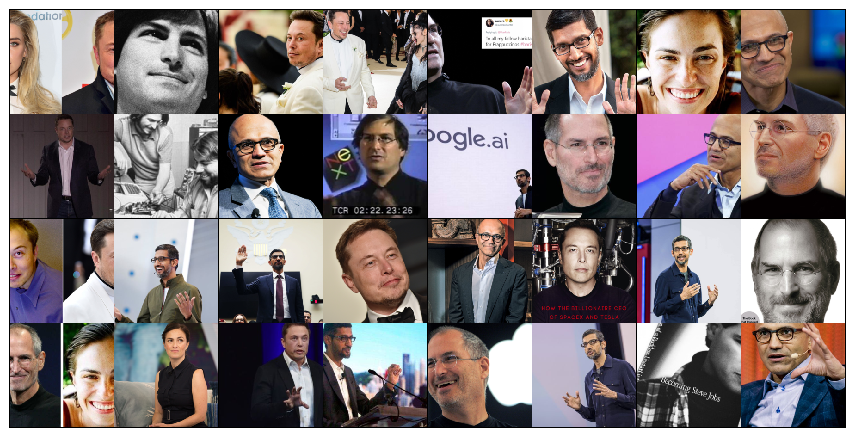

In [7]:
image_grid = utils.make_grid(images)
plot_image(image_grid, figsize=(15,15))

### Prepare training dataset

In [ ]:
transformation = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [ ]:
dataset = {x: datasets.ImageFolder(os.path.join(root_folder, x), transformation[x]) for x in ['train', 'valid']}
loader = {x: torch.utils.data.DataLoader(dataset[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid']}

dataset_size = {x: len(dataset[x]) for x in ['train', 'valid']}
class_names = dataset['train'].classes

In [10]:
dataset_size

{'train': 550, 'valid': 285}

In [11]:
class_names

['Elon Musk', 'Satya Nadella', 'Steve Jobs', 'Sundar Pichai']

## Finetune resnet
We will use pretrained model on top of which we will place small classification feed forward network. Then we will train this whole architecture in 2 steps:   

1) fix of Resnet pretrained weights and tain just our simple added classifier     
2) use smaller learning rate and adjust also top layers of Resnet


### Classify with original renset

In [ ]:
plot_classify(dataset['valid'][4][0], resnet18, topn=10, category_names=get_imagenet_category_names())

### Setup model

In [29]:
output_size = len(dataset['train'].classes)
output_size

4

In [ ]:
resnet18 = models.resnet18(pretrained=True).cuda()

In [ ]:
resnet18.fc = torch.nn.Sequential(
    torch.nn.Linear(512, output_size),
    torch.nn.Softmax(dim=1))

loss_fce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.fc.parameters())

### Basic finetuning of last layers

In [ ]:
for param in resnet18.parameters():
    param.requires_grad = False

In [ ]:
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [ ]:
def get_valid_acc_and_loss(model, loss_fce, valid_loader):
    accuracy = 0
    loss = 0
    was_training = model.training
    model.eval()
    
    for images, labels in valid_loader:
        images = images.cuda()
        labels = labels.cuda()
        predictions = model(images)
        accuracy += (predictions.argmax(dim=1) == labels).type(torch.FloatTensor).mean().item() 
        loss += loss_fce(predictions, labels).item()
    
    model.train(mode=was_training)
    return accuracy / len(valid_loader) * 100, loss / len(valid_loader)

In [ ]:
# Initial params setup.
model = resnet18
model = model.cuda()
epochs = 20
report_period = 15
batch_iteration = 0

# Storing of some data.
train_leak_loss = deque(maxlen=report_period)
train_loss_history = []
valid_loss_history = []
valid_acc_history = []

In [48]:
for epoch in range(epochs):
    # Setup net to train mode and go through one epoch.
    model.train()
    for images, labels in loader['train']:
        images = images.cuda()
        labels = labels.cuda()
        batch_iteration += 1
        
        # Training net on one batch.
        optimizer.zero_grad()
        predictions = model.forward(images)
        loss = loss_fce(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_leak_loss.append(loss.item())
        # In case we should report, lets make validation on valid set.
        if batch_iteration % report_period == 0:
            model.eval()
            # We don't want to collect info for gradients from here.
            with torch.no_grad():
                valid_accuracy, valid_loss = get_valid_acc_and_loss(model, loss_fce, loader['valid'])
                
            print(f'Epoch: {epoch+1}/{epochs}.. ',
                  f"Train Loss: {round(np.mean(train_leak_loss), 2)}.. ",
                  f"Valid Loss: {round(valid_loss, 2)}.. ",
                  f"Valid Acc: {round(valid_accuracy, 2)}%")
            
            train_loss_history.append(np.mean(train_leak_loss))
            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_accuracy)
                        
            model.train()

Epoch: 1/10..  Train Loss: 0.98..  Valid Loss: 0.89..  Valid Acc: 86.0%
Epoch: 2/10..  Train Loss: 0.91..  Valid Loss: 0.88..  Valid Acc: 87.74%
Epoch: 3/10..  Train Loss: 0.94..  Valid Loss: 0.86..  Valid Acc: 88.47%
Epoch: 4/10..  Train Loss: 0.9..  Valid Loss: 0.84..  Valid Acc: 91.32%
Epoch: 5/10..  Train Loss: 0.89..  Valid Loss: 0.85..  Valid Acc: 89.82%
Epoch: 5/10..  Train Loss: 0.89..  Valid Loss: 0.84..  Valid Acc: 89.16%
Epoch: 6/10..  Train Loss: 0.87..  Valid Loss: 0.84..  Valid Acc: 91.52%
Epoch: 7/10..  Train Loss: 0.87..  Valid Loss: 0.84..  Valid Acc: 91.59%
Epoch: 8/10..  Train Loss: 0.86..  Valid Loss: 0.86..  Valid Acc: 88.85%
Epoch: 9/10..  Train Loss: 0.85..  Valid Loss: 0.86..  Valid Acc: 88.36%
Epoch: 10/10..  Train Loss: 0.84..  Valid Loss: 0.85..  Valid Acc: 90.37%
Epoch: 10/10..  Train Loss: 0.86..  Valid Loss: 0.85..  Valid Acc: 89.55%


### Extra finetuning of resnet layer4
Nice reading about advanced strategies for setup of lr here: ***https://www.jeremyjordan.me/nn-learning-rate/***

 - let's setup as trainable parameters of last layer of resnet model
 - make learning rate 10 times smaller
 - re-run previous training cell with adjusted setup

In [41]:
optimizer.param_groups[0]['lr']

0.001

In [42]:
optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[ 0.1329,  0.0032, -0.0213,  ...,  0.0003,  0.0107,  0.0044],
         [-0.0776,  0.0697, -0.0180,  ..., -0.0181,  0.0332,  0.0710],
         [ 0.0199, -0.0199, -0.0364,  ..., -0.0190, -0.0929, -0.0591],
         [-0.0781,  0.0259,  0.0062,  ...,  0.0044,  0.0044, -0.0650]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-0.0011, -0.0435, -0.0400,  0.0323], device='cuda:0',
        requires_grad=True)]

In [ ]:
epochs=10

In [ ]:
for param in model.layer4.parameters():
    param.requires_grad = True

In [ ]:
optimizer.param_groups[0]['params'] = optimizer.param_groups[0]['params'] + list(model.layer4.parameters())

In [ ]:
optimizer.param_groups[0]['lr'] = 0.0001

**Go back and re-run training cell**

### After all training save the model

In [ ]:
training_state = {
    'optimizer': optimizer.param_groups,
    'net': model.state_dict()
}

In [ ]:
torch.save(training_state, './drive/My Drive/ml_college_data/models/finetuned_resnet.pth')

## Visualize progress of training

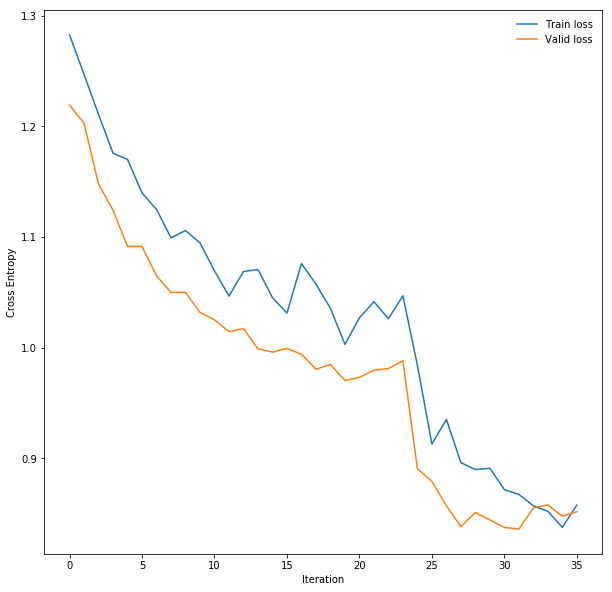

In [51]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Cross Entropy')
plt.plot(train_loss_history, label='Train loss')
plt.plot(valid_loss_history, label='Valid loss')
plt.legend(frameon=False)

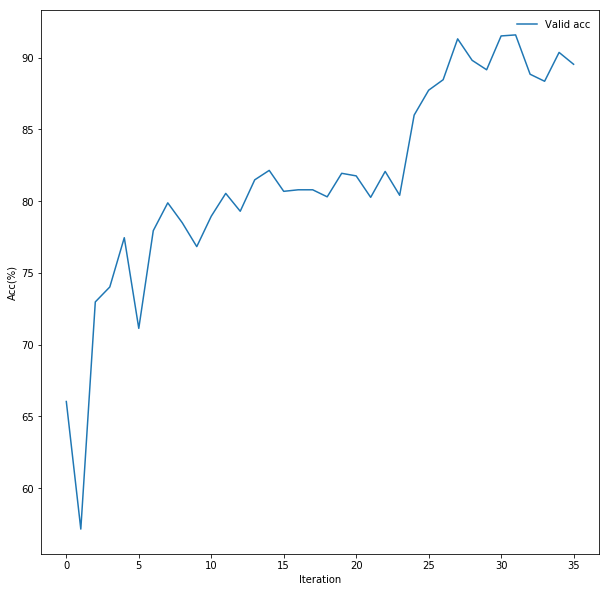

In [52]:
fig = plt.figure(figsize=(10, 10))
plt.plot(valid_acc_history, label='Valid acc')
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Acc(%)')
plt.legend(frameon=False)

## Results evaluation

In [55]:
info = model.eval()
model.cpu()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### View single images and predictions

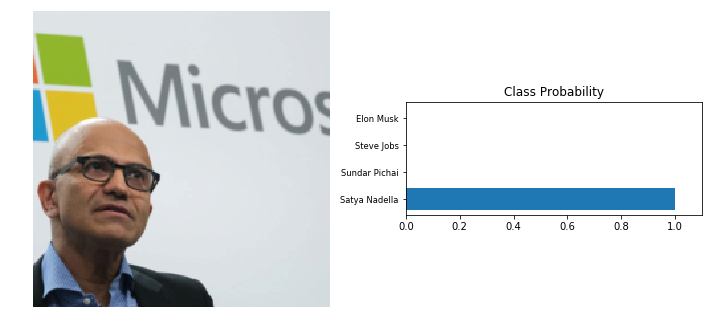

In [56]:
plot_classify(dataset['valid'][120][0], model, category_names=class_names)

### Load reuslts to pandas df

In [57]:
df = get_results_df(model, loader['valid'])
df.head(10)

,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_score_top1,image
0,Sundar Pichai,0.999723,Sundar Pichai,0.999723,"[[[1.6152923107147217, 1.5810428857803345, 1.5..."
1,Sundar Pichai,0.968028,Sundar Pichai,0.968028,"[[[-1.3472901582717896, -1.3472901582717896, -..."
2,Sundar Pichai,0.883861,Sundar Pichai,0.883861,"[[[-2.1007792949676514, -2.1179039478302, -2.1..."
3,Sundar Pichai,0.795601,Sundar Pichai,0.795601,"[[[-1.878157377243042, -1.878157377243042, -1...."
4,Steve Jobs,0.999985,Steve Jobs,0.999985,"[[[-0.9020463824272156, -1.4842880964279175, -..."
5,Sundar Pichai,0.999909,Sundar Pichai,0.999909,"[[[1.8036646842956543, 1.8036646842956543, 1.8..."
6,Sundar Pichai,0.999572,Sundar Pichai,0.999572,"[[[-0.4739275872707367, -0.5081771016120911, -..."
7,Satya Nadella,0.763190,Satya Nadella,0.763190,"[[[1.0844250917434692, 0.9645517468452454, 0.8..."
8,Satya Nadella,0.999977,Satya Nadella,0.999977,"[[[1.2042982578277588, 1.2385478019714355, 1.1..."
9,Elon Musk,0.999998,Elon Musk,0.999998,"[[[-2.1179039478302, -2.1179039478302, -2.1179..."


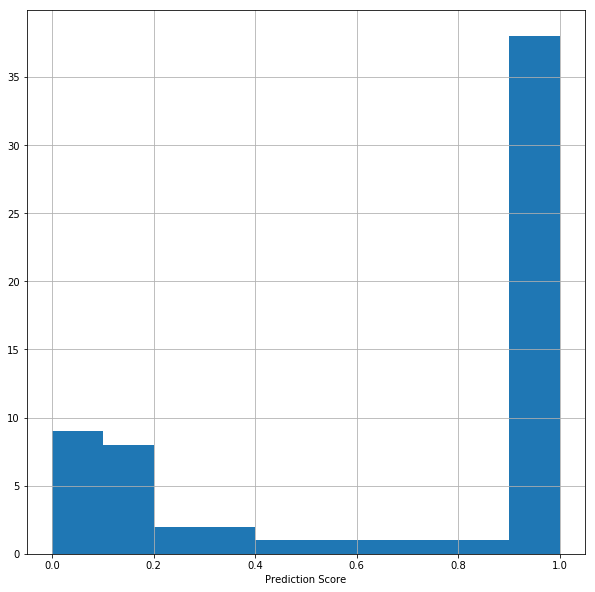

In [58]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Prediction Score')
df[df.label_class_name=='Steve Jobs'].label_class_score.hist(ax=ax)

### Basic Metrics


In [59]:
get_rec_prec(df, class_names)

,class_name,recall,precision
0,Elon Musk,100.00,79.17
1,Satya Nadella,95.59,94.20
2,Steve Jobs,65.62,95.45
3,Sundar Pichai,93.51,94.74


In [60]:
get_accuracy(df)

89.47

### False Positives

In [62]:
fp = get_false_positives(df, label_class_name='Elon Musk')
plot_df_examples(fp)

<Figure size 1440x1800 with 0 Axes>

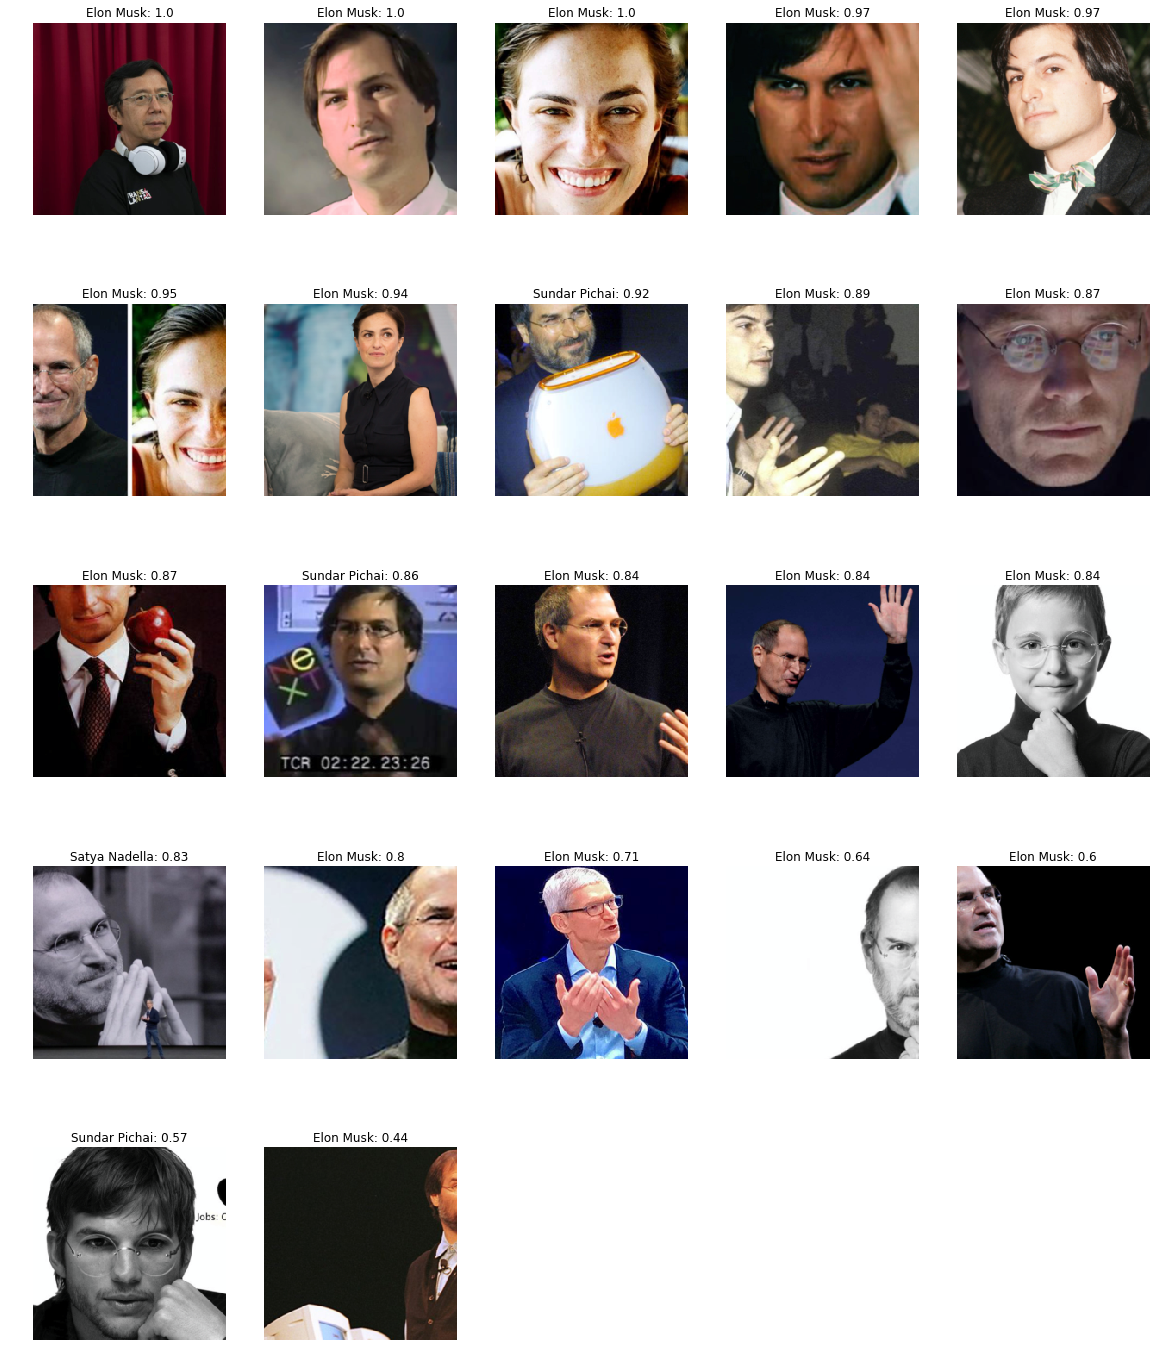

In [63]:
fp = get_false_positives(df, label_class_name='Steve Jobs')
plot_df_examples(fp)

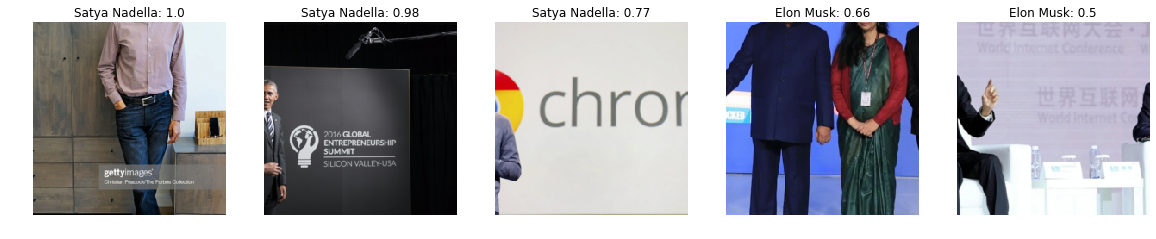

In [64]:
fp = get_false_positives(df, label_class_name='Sundar Pichai')
plot_df_examples(fp)

### Confusion Matrix

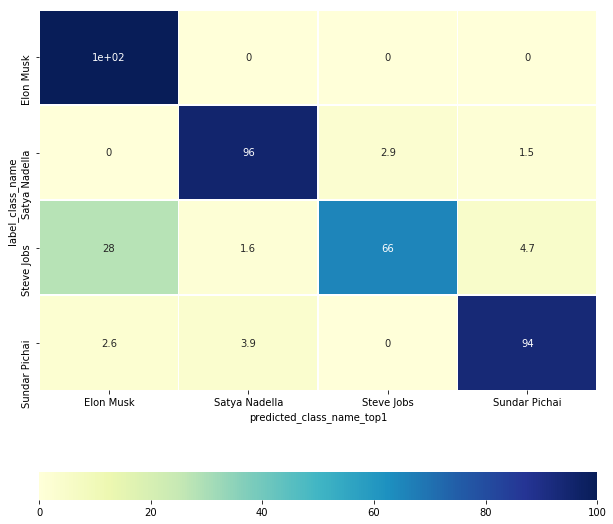

In [65]:
plot_coocurance_matrix(df, use_log=False)